In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS =10
BS = 32

In [3]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    if(label!="without_mask"):
        label="with_mask"

	# load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

	# update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

[INFO] loading images...


In [4]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [5]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [6]:
# left off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

/home/himansh/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [9]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/10
41/41 [==============================] - 212s 5s/step - loss: 0.5411 - accuracy: 0.7416 - val_loss: 0.1081 - val_accuracy: 0.9821
Epoch 2/10
41/41 [==============================] - 209s 5s/step - loss: 0.2325 - accuracy: 0.9083 - val_loss: 0.0512 - val_accuracy: 0.9911
Epoch 3/10
41/41 [==============================] - 212s 5s/step - loss: 0.1606 - accuracy: 0.9450 - val_loss: 0.0399 - val_accuracy: 0.9911
Epoch 4/10
41/41 [==============================] - 213s 5s/step - loss: 0.1308 - accuracy: 0.9511 - val_loss: 0.0291 - val_accuracy: 0.9940
Epoch 5/10
41/41 [==============================] - 214s 5s/step - loss: 0.0935 - accuracy: 0.9717 - val_loss: 0.0233 - val_accuracy: 0.9940
Epoch 6/10
41/41 [==============================] - 214s 5s/step - loss: 0.0848 - accuracy: 0.9687 - val_loss: 0.0229 - val_accuracy: 0.9940
Epoch 7/10
41/41 [==============================] - 213s 5s/step - loss: 0.0758 - accuracy: 0.9778 - val_loss: 0.0211 - val_accura

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       198
without_mask       0.99      1.00      0.99       138

    accuracy                           0.99       336
   macro avg       0.99      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336

[INFO] saving mask detector model...


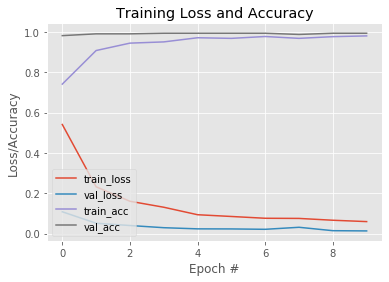

In [11]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("model_resnet.h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("resnet_graph.jpg")
plt.show()
